In [1]:
# ! pip install jugaad_data, nsetools
from jugaad_data.nse import stock_df
from nsetools import Nse

from datetime import date, datetime, timedelta
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import mplfinance as fplt
import plotly.graph_objects as go

from multiprocessing import Pool

import requests
from bs4 import BeautifulSoup
import random

from os import listdir
from os.path import isfile, join

import json

import warnings

import math

In [ ]:
assert False 

def get_stocks(name):
    try:
        df = stock_df(symbol=name, from_date = current_date - timedelta(days = 365), to_date = current_date, series="EQ").drop(drop,axis=1)
        df.to_csv(f"./data/{name}_{all_stocks[name]}_{str(current_date)}.csv",index=None)
    except Exception as e:
        print(e)
        pass
 
path = './data'
AS = AnalyseStocks()
all_stocks = {}
for key in AS.all_stocks:
    all_stocks[key] = AS.all_stocks[key].split('_')[0]

for f in listdir(path):
    if isfile(join(path, f)):
        split = f.split('_')[0]
        if split in all_stocks:
            del all_stocks[split]

drop = ['SERIES','PREV. CLOSE','VWAP','52W H','52W L','VOLUME','VALUE','NO OF TRADES']
current_date = date.today()
stocks = list(all_stocks.keys())
random.shuffle(stocks)


pool = Pool(3)
results = pool.map(get_stocks,stocks)
pool.close()
pool.join()

# Code

In [2]:
class AnalyseStocks:
    def __init__(self, data_path:str = './data'):
        '''
        args:
            path: Path where all the stock files are saved
        '''
        self.path = data_path
        self.eligible = {}
        
        with open('./names/all_stocks.json') as f:
            self.all_stocks = json.load(f)
   

    def _update_all_stock_names(self):
        '''
        Get all the names of stocks and dictonary of filenames by their ID given by NSE
        args:
            path: PAth where all the stock files are saved
        out: Dictonary of {NSE_ID: Name_of_file}
        '''
        
        for f in listdir(self.path):
            if isfile(join(self.path, f)):
                split = f.split('_')
                self.all_stocks[split[0]] = split[1]+'_'+split[2]
                      
        
    def open_stock(self,name:str):
        '''
        Open the Individual stock based on it's Official Term
        args:
            name: Name / ID given to the stock. Example, Infosys is "INFY"
        returns: DataFrame of that stock
        '''
        return pd.read_csv(join(self.path,name+'_'+self.all_stocks[name]))
    

    def is_eligible(self, df, mv = 44, names:tuple = ('DATE','OPEN','CLOSE','LOW','HIGH')):
        '''
        Find the Positive Stocks which are about to rise on the Moving average line
        args:
            df: DataFrame
            mv: Moving Average to Consider
            names: Tuple of column names showing ('DATE','OPEN','CLOSE','LOW','HIGH')
        '''
        Date, Open, Close, Low, High = names
        Average = f'{str(mv)}-SMA'
        
        stocks = df.sort_index(ascending=False,) # Sort the values else Moving average for new values will be empty
        stocks[Average] = stocks[Close].rolling(mv, min_periods = 1).mean()
        
        last_traded = stocks.iloc[-1,:]
        if (last_traded[Close] > last_traded[Open]) and (last_traded[Close] > last_traded[Average]) and (0 <= (last_traded[Low] - last_traded[Average]) <= last_traded[Close] - last_traded[Open]):
            return {last_traded['SYMBOL'] : round(last_traded[Low] - last_traded[Average],2)}

        return False
    
    
    def update_eligible(self):
        '''
        Save all Eligible stocks for the current week
        '''
        for key in self.all_stocks.keys():
            result = self.is_eligible(self.open_stock(key))
            if result:
                self.eligible.update(result)
                        
        with open(f'./week_by_week_eligible/{str(date.today())}.json', 'w') as f:
            json.dump({k: v for k, v in sorted(self.eligible.items(), key=lambda item: item[1])} , f)
            
    
    def plot_candlesticks(self,df, names = ('DATE','OPEN','CLOSE','LOW','HIGH'), mv = 44):
        '''
        Plot a candlestick on a given dataframe
        args:
            df: DataFrame
            names: Tuple of column names showing ('DATE','OPEN','CLOSE','LOW','HIGH')
            mv: Moving Average
        '''
        stocks = df.copy()
        Date, Open, Close, Low, High = names
        
        if not f'{str(mv)}-SMA' in stocks.columns:
            stocks.sort_index(ascending=False, inplace = True)
            stocks[f'{str(mv)}-SMA'] = stocks[Close].rolling(mv, min_periods = 1).mean()

        candle = go.Figure(data = [go.Candlestick(x = stocks[Date], name = 'Trade',
                                                       open = stocks[Open], 
                                                       high = stocks[High], 
                                                       low = stocks[Low], 
                                                       close = stocks[Close]),

                                  go.Scatter(name=f'{str(mv)} MA',x=stocks[Date], y=stocks[f'{str(mv)}-SMA'], 
                                             line=dict(color='blue', width=1)),])

        candle.update_xaxes(
            title_text = 'Date',
            rangeslider_visible = True,
            rangeselector = dict(
                buttons = list([
                    dict(count = 1, label = '1M', step = 'month', stepmode = 'backward'),
                    dict(count = 6, label = '6M', step = 'month', stepmode = 'backward'),
                    dict(count = 1, label = 'YTD', step = 'year', stepmode = 'todate'),
                    dict(count = 1, label = '1Y', step = 'year', stepmode = 'backward'),
                    dict(step = 'all')])))

        candle.update_layout(autosize = True,
                             title = {'text': f"{stocks['SYMBOL'][0]} | {self.all_stocks[stocks['SYMBOL'][0]]}",'y':0.97,'x':0.5,
                                      'xanchor': 'center','yanchor': 'top'},
                             margin=dict(l=30,r=30,b=30,t=30,pad=2),
                             paper_bgcolor="lightsteelblue",)

        candle.update_yaxes(title_text = 'Price in Rupees', tickprefix = u"\u20B9" ) # Rupee symbol
        candle.show()

# Investing

In [75]:
class Investing:
    def __init__(self,loss_capacity, greed_ratio:float=2, max_budget=1000, rolling_mean:int=44):
        '''
        args:
            max_budget: Maximum budget that you can spend. Any Share's price must be less than the budget
            loss_capacity: How much loss you can survive at the end of day PER SHARE. Total capacity will be No of shares * per share loss capacity
            greed_ratio: How much profit you want to have. It is twice of loss_capacity per share for 44 Moving average
        '''
        self.max_budget = max_budget
        self.risk = loss_capacity # per share
        self.greed_ratio = greed_ratio
        self.rm = rolling_mean
        self.eligible = None
        
    
    def get_eligible_for_week(self, path = './week_by_week_eligible/'):
        '''
        Get Most Recent Stocks updated
        path: Path of json file 
        '''
        if len(listdir(path)) == 0:
            AnalyseStocks().update_eligible()

        files = []  
        for f in listdir(path):
            if isfile(join(path, f)):
                files.append(join(path,f))

        files.sort()
        eligible = files[0]
        delta = date.today() - date.fromisoformat(eligible.split('/')[-1].split('.')[0])

        if delta.days >= 10:
            warnings.warn('This dats is older than 10 days. Please fetch a new Data')

        else:    
            with open(eligible) as f:
                self.eligible = json.load(f)
    
    
    def pick(self, High = 'HIGH', Close = 'CLOSE', delta:float=0.01):
        '''
        Pick Stocks based on all available and which are within your budget
        args:
            High: Column name which show High
            Close: Column Name which shows last closing price
            delta: Value above the Last Highest Traded Price
        '''
        if not self.eligible:
            self.get_eligible_for_week()
            
        values = []
        keys = list(self.eligible.keys())
        for key in keys:
            df = AnalyseStocks().open_stock(key)
            if df.loc[0,High] + delta > self.max_budget or df.loc[0,Close] < 50:
                del self.eligible[key]
                
            else:
                values.append(df.iloc[0,:])
                
        df = pd.DataFrame(values,columns=df.columns,index = range(len(values)))
        df = df.merge(pd.DataFrame({'SYMBOL':self.eligible.keys(), 'Diff':self.eligible.values()}),on='SYMBOL')
        self.picked = df.sort_values('Diff',ascending = True)
        return self.picked
                
                   
    def get_purchase_history():
        '''
        Get shares already purchased for the 10 days period
        '''
        pass
    
    
    def show_particulars(self, df, Low = 'LOW', High = 'HIGH', delta = 0.3):
        '''
        Display the particulars of a trade before buying
        args:
            df: DtaFrame of a particular stock
            Low: Column name which describes LOW of the previous trade
            High =  Column name which describes High of the previous trade
            delta: A min amount above which you'll buy
        '''
        entry = df.loc[0,High] + delta # Last Day MAX + Delta
        stop_loss = min(df.loc[:2,Low].values) # Min of the last 2 
        diff = entry - stop_loss
        quantity = self.risk / diff
        profit = self.greed_ratio * diff
        target = entry + profit
        return {'Entry':entry,'Stop Loss':stop_loss,'Quantity':quantity, 'Target':target}

In [79]:
In = Investing(50,2,1000)
As = AnalyseStocks()
df = In.pick()
# X = df['SYMBOL'].values

# As.plot_candlesticks(As.open_stock(X[0]))

In.show_particulars(As.open_stock('UNIDT'))

{'Entry': 334.2,
 'Stop Loss': 326.05,
 'Quantity': 6.134969325153391,
 'Target': 350.49999999999994}

# MPL

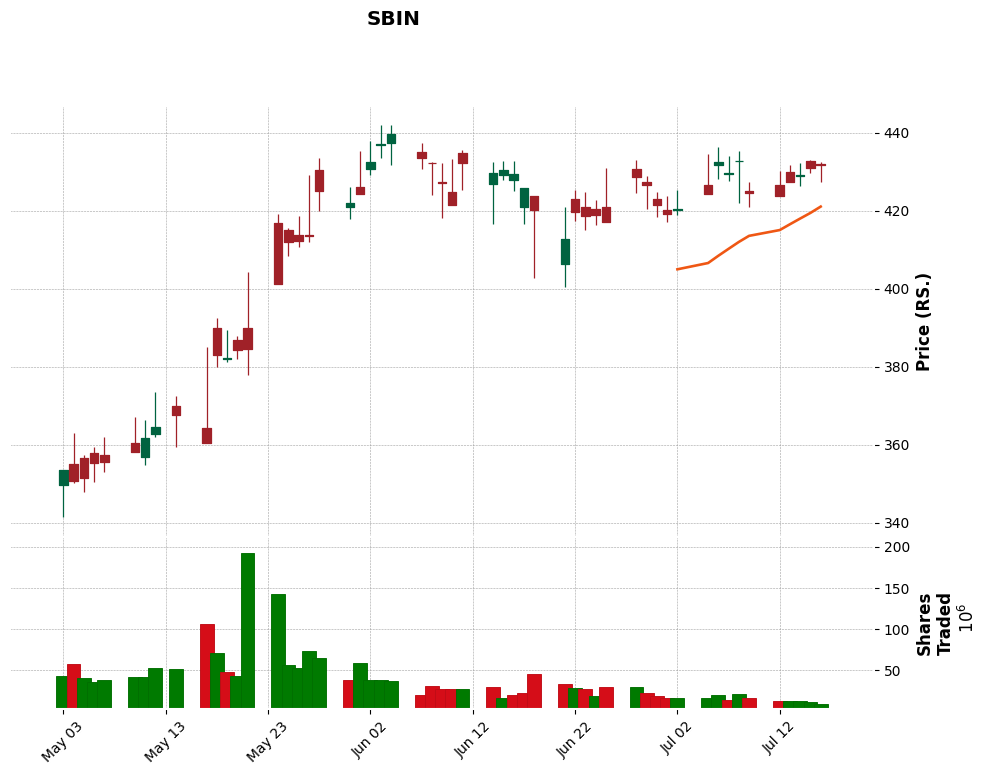

In [8]:
df = stocks.copy()
df.sort_index(ascending=False, inplace = True)
df['44-SMA'] = df['PREV. CLOSE'].rolling(44, min_periods = 1).mean()

df1 = df.copy()
df1.set_index('DATE',drop=True,inplace=True)
df1.rename(columns={'OPEN':'Open','HIGH':'High','LOW':'Low', 'PREV. CLOSE':'Close', 'VOLUME':'Volume'},inplace=True)

fplt.plot(df1,type='candle', style='charles', title=df['SYMBOL'][0], ylabel='Price (RS.)', volume=True, ylabel_lower='Shares\nTraded', 
          show_nontrading=True,mav=44,figscale=1.5,)